In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et 
from geopy.geocoders import Nominatim
import pycountry
from countryinfo import CountryInfo
from difflib import SequenceMatcher
pd.options.mode.chained_assignment = None

In [2]:
def load_users():
    xtree = et.parse("./data/datascience_stackexchange_com/Users.xml")
    xroot = xtree.getroot() 
    df_cols = ["Id", "Reputation", "CreationDate", "Location","Views", "AccountId"]
    rows = []
    for x in xroot:
        uId = x.attrib['Id']
        if 'AccountId' in x.attrib:
            uAccountId = x.attrib['AccountId']
        else:
            uAccountId = None
        if 'Location' in x.attrib:
            uLocation = x.attrib['Location']
        else:
            uLocation = None
        uReputation = x.attrib['Reputation']
        uCreationDate = x.attrib['CreationDate']
        uViews = x.attrib['Views']
        rows.append({"Id": uId, "Reputation": uReputation, 
                     "CreationDate": uCreationDate, "Location": uLocation,"Views":uViews,"AccountId":uAccountId})
    user_df = pd.DataFrame(rows, columns = df_cols)
    return user_df

def retired_assign_country(df):
    countries = dict()
    for index, addr in df.iterrows():
        item = addr['Location'].split(',')[-1]
        try:
            ct = (pycountry.countries.search_fuzzy(item)[0]).name
            countries[addr['Id']] = ct
        except LookupError:
            continue


def load_posts():
    xtree = et.parse("./data/datascience_stackexchange_com/Posts.xml")
    xroot = xtree.getroot() 
    df_cols = ["Id","PostTypeId", "ParentID","AcceptedAnswerId","CreationDate","Score","ViewCount","OwnerUserId","Tags"]
    rows = []
    for x in xroot:
        row = dict()
        for col in df_cols:
            if col in x.attrib:
                row[col] = x.attrib[col]
            else:
                row[col] = None
        rows.append(row)
    user_df = pd.DataFrame(rows, columns = df_cols)
    return user_df

def load_tags():
    tag_rows = []
    cols = ["Id","Tag"]
    for index, row in data_posts.iterrows():
        pid = row['Id']
        tag = row['Tags']
        if tag is not None:
            tags = re.split('><|>|<',tag) 
            for t in tags:
                if len(t.strip())>0:
                    tag_rows.append({"Id":pid,"Tag":t})
        else:
            tag_rows.append({"Id":pid,"Tag":None})
    data_tags = pd.DataFrame(tag_rows, columns = cols)
    return data_tags

##########Retired Code
#for index, row in df_users_full.iterrows():
#    item = (row['Location_x'].split(',')[-1]).strip()
#    if (item=='ny'):
#        df_users_full.at[index,'Location_y'] = 'United States'
#df_countries = df_users_full[['Id','Location_y']]
#df_countries.to_csv (r'./country_list.csv', index = None)   
#df_users_full.fillna('Unknown', inplace=True)

In [3]:
shapefile = './data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
worldmap = gpd.read_file(shapefile)
worldmap = worldmap[['ADMIN','ADM0_A3','geometry']]
worldmap = worldmap.drop(worldmap.index[159])

In [4]:
user_countries = pd.read_csv('./data/country_list_4.csv')

In [5]:
worldmap.shape

(176, 3)

In [6]:
worldmap.head()

,ADMIN,ADM0_A3,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [7]:
cities = pd.read_csv('./data/worldcities.csv')
cities = gpd.GeoDataFrame(cities[['country','city','lat','lng']],geometry=gpd.points_from_xy(cities.lng, cities.lat))
cities.head()

,country,city,lat,lng,geometry
0,Kosovo,Malishevë,42.4822,20.7458,POINT (20.74580 42.48220)
1,Kosovo,Prizren,42.2139,20.7397,POINT (20.73970 42.21390)
2,Kosovo,Zubin Potok,42.9144,20.6897,POINT (20.68970 42.91440)
3,Kosovo,Kamenicë,42.5781,21.5803,POINT (21.58030 42.57810)
4,Kosovo,Viti,42.3214,21.3583,POINT (21.35830 42.32140)


In [8]:
df_users = load_users()
print(df_users.shape)
df_users.head()

(66951, 6)


,Id,Reputation,CreationDate,Location,Views,AccountId
0,-1,1,2014-05-13T21:29:22.820,on the server farm,0,-1
1,1,101,2014-05-13T22:58:54.810,"New York, NY",453,37099
2,2,101,2014-05-13T22:59:19.787,"Corvallis, OR",9,2
3,3,101,2014-05-13T23:15:34.483,None,7,3046327
4,4,101,2014-05-13T23:16:09.937,Republic of Texas,9,2365


In [9]:
df_users['Id'] = pd.to_numeric(df_users['Id'])
df_users['CreationDate'] = pd.to_datetime(df_users['CreationDate'], format="%Y-%m-%d %H:%M:%S")
df_users.head()

,Id,Reputation,CreationDate,Location,Views,AccountId
0,-1,1,2014-05-13 21:29:22.820,on the server farm,0,-1
1,1,101,2014-05-13 22:58:54.810,"New York, NY",453,37099
2,2,101,2014-05-13 22:59:19.787,"Corvallis, OR",9,2
3,3,101,2014-05-13 23:15:34.483,None,7,3046327
4,4,101,2014-05-13 23:16:09.937,Republic of Texas,9,2365


In [10]:
df_users.isnull().any()

Id              False
Reputation      False
CreationDate    False
Location         True
Views           False
AccountId        True
dtype: bool

In [11]:
bool_series = pd.notnull(df_users['AccountId']) 
df_users = df_users[bool_series]
len(df_users)

66946

In [12]:
bool_series = pd.notnull(df_users['Location']) 
df_users_loc = df_users[bool_series]
df_users_loc = df_users_loc[df_users_loc.Id>=1]

In [13]:
print(df_users_loc.shape)
df_users_loc.head()

(29306, 6)


,Id,Reputation,CreationDate,Location,Views,AccountId
1,1,101,2014-05-13 22:58:54.810,"New York, NY",453,37099
2,2,101,2014-05-13 22:59:19.787,"Corvallis, OR",9,2
4,4,101,2014-05-13 23:16:09.937,Republic of Texas,9,2365
5,5,150,2014-05-13 23:16:11.013,"Texas, US",27,1266491
6,6,101,2014-05-13 23:16:26.517,"Dietzenbach, Deutschland",10,935589


In [14]:
bool_series = pd.isnull(df_users['Location']) 
df_users_nolocation = df_users[bool_series]

In [15]:
print(df_users_nolocation.shape)
df_users_nolocation.head()

(37639, 6)


,Id,Reputation,CreationDate,Location,Views,AccountId
3,3,101,2014-05-13 23:15:34.483,None,7,3046327
7,7,101,2014-05-13 23:17:05.443,None,4,1703573
13,14,2322,2014-05-13 23:24:41.720,None,102,92888
15,16,1,2014-05-13 23:25:24.423,None,1,851
17,18,101,2014-05-13 23:27:57.393,None,1,164368


In [16]:
len(df_users_nolocation)/len(df_users)*100

56.2229259403101

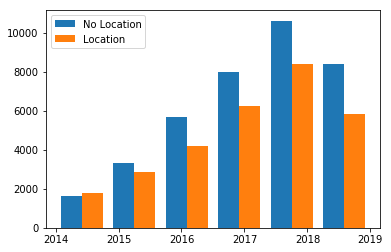

In [17]:
plt.hist([df_users_nolocation.CreationDate.dt.year,df_users_loc.CreationDate.dt.year], bins=6, label=["No Location","Location"])
plt.legend()

In [18]:
df_users_loc.head()

,Id,Reputation,CreationDate,Location,Views,AccountId
1,1,101,2014-05-13 22:58:54.810,"New York, NY",453,37099
2,2,101,2014-05-13 22:59:19.787,"Corvallis, OR",9,2
4,4,101,2014-05-13 23:16:09.937,Republic of Texas,9,2365
5,5,150,2014-05-13 23:16:11.013,"Texas, US",27,1266491
6,6,101,2014-05-13 23:16:26.517,"Dietzenbach, Deutschland",10,935589


In [19]:
user_countries.head()

,Id,Country
0,1,United States of America
1,2,United States of America
2,4,Unknown
3,5,United States of America
4,6,Germany


In [20]:
df_users_full= pd.merge(df_users_loc, user_countries, on='Id',  how='left')
df_users_full[df_users_full['Country']!='Unknown'].head()

,Id,Reputation,CreationDate,Location,Views,AccountId,Country
0,1,101,2014-05-13 22:58:54.810,"New York, NY",453,37099,United States of America
1,2,101,2014-05-13 22:59:19.787,"Corvallis, OR",9,2,United States of America
3,5,150,2014-05-13 23:16:11.013,"Texas, US",27,1266491,United States of America
4,6,101,2014-05-13 23:16:26.517,"Dietzenbach, Deutschland",10,935589,Germany
6,9,1042,2014-05-13 23:18:21.653,Canada,27,1369656,Canada


In [21]:
df_unknown = df_users_full[df_users_full['Country']=='Unknown']
df_unknown.shape

(1860, 7)

In [22]:
users_data_full = df_users_full[df_users_full['Country']!='Unknown']
users_data_full.shape

(27446, 7)

In [23]:
(27446/29306)*100

93.6531768238586

In [24]:
country_summary = users_data_full.groupby('Country')['AccountId'].agg('count').reset_index()
country_summary.columns  = ['ADMIN', 'population']
country_summary.head()

,ADMIN,population
0,Afghanistan,2
1,Albania,4
2,Algeria,56
3,American Samoa,2
4,Antarctica,5


In [25]:
worldmap.head()

,ADMIN,ADM0_A3,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [26]:
user_map= pd.merge(worldmap, country_summary, on='ADMIN',  how='left')
user_map['population'].fillna(0, inplace=True)
user_map_over = user_map[user_map['population']>0]
user_map_under = user_map[user_map['population']==0]

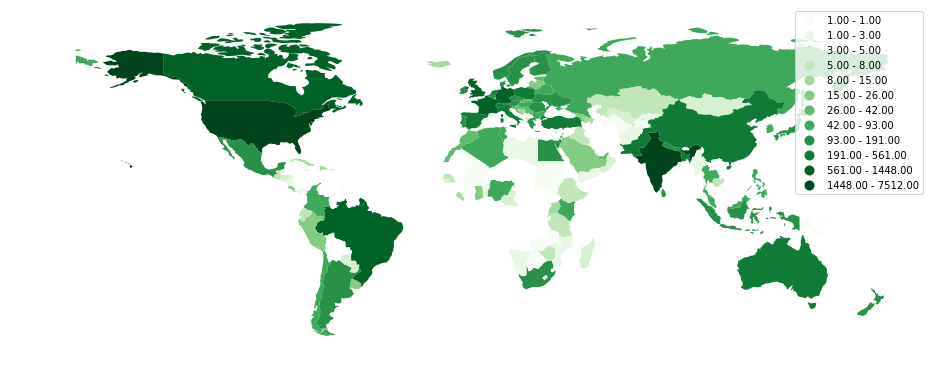

In [27]:
fig, ax = plt.subplots(figsize = (16,9))
user_map_over.plot(ax = ax, column = 'population', k = 12 ,cmap='Greens', scheme='jenks_caspall', legend=True)
user_map_under.plot(ax = ax, color='w',legend=True)
ax.set_axis_off()
plt.show()

### Testing Tag distibution by country: Failed

In [28]:
df_users_full['YearCreated'] = df_users_full.CreationDate.dt.year
df_users_full.head()

,Id,Reputation,CreationDate,Location,Views,AccountId,Country,YearCreated
0,1,101,2014-05-13 22:58:54.810,"New York, NY",453,37099,United States of America,2014
1,2,101,2014-05-13 22:59:19.787,"Corvallis, OR",9,2,United States of America,2014
2,4,101,2014-05-13 23:16:09.937,Republic of Texas,9,2365,Unknown,2014
3,5,150,2014-05-13 23:16:11.013,"Texas, US",27,1266491,United States of America,2014
4,6,101,2014-05-13 23:16:26.517,"Dietzenbach, Deutschland",10,935589,Germany,2014


In [29]:
data_posts = load_posts()

In [30]:
tags = load_tags()

In [31]:
data_posts_part = data_posts[['Id','PostTypeId','CreationDate','Score','ViewCount','AcceptedAnswerId','ParentID','OwnerUserId']]
data_posts_part['CreationDate'] = pd.to_datetime(data_posts_part['CreationDate'], format="%Y-%m-%d %H:%M:%S")
data_posts_part['YearCreated'] = data_posts_part.CreationDate.dt.year
data_posts_part.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,AcceptedAnswerId,ParentID,OwnerUserId,YearCreated
0,5,1,2014-05-13 23:58:30.457,8,604,None,None,5,2014
1,7,1,2014-05-14 00:11:06.457,4,426,10,None,36,2014
2,9,2,2014-05-14 00:36:31.077,5,None,None,None,51,2014
3,10,2,2014-05-14 00:53:43.273,12,None,None,None,22,2014
4,14,1,2014-05-14 01:25:59.677,23,1495,29,None,66,2014


In [32]:
data_posts_temp = pd.merge(data_posts_part, tags, on='Id',  how='right')
data_posts_temp = data_posts_temp[['PostTypeId','YearCreated','OwnerUserId','Tag']]
print(data_posts_temp.shape)
data_posts_temp.head()

(75368, 4)


,PostTypeId,YearCreated,OwnerUserId,Tag
0,1,2014,5,machine-learning
1,1,2014,36,education
2,1,2014,36,open-source
3,2,2014,51,None
4,2,2014,22,None


In [33]:
data_posts_temp = data_posts_temp[data_posts_temp['Tag'].notna()]
data_posts_temp.shape

(53952, 4)

In [34]:
data_posts_temp.head()

,PostTypeId,YearCreated,OwnerUserId,Tag
0,1,2014,5,machine-learning
1,1,2014,36,education
2,1,2014,36,open-source
5,1,2014,66,data-mining
6,1,2014,66,definitions


In [35]:
data_posts_temp['OwnerUserId'].nunique()

10531

In [36]:
sample_data = df_users_full[['AccountId','Country']]
sample_data.columns = ['OwnerUserId','Country']
sample_data.head()

,OwnerUserId,Country
0,37099,United States of America
1,2,United States of America
2,2365,Unknown
3,1266491,United States of America
4,935589,Germany


In [37]:
sample_data_posts = pd.merge(data_posts_temp, sample_data, on='OwnerUserId',  how='left')
sample_data_posts.shape

(53952, 5)

In [38]:
data_x = sample_data_posts[sample_data_posts['Country'].notna()]
data_x.shape

(983, 5)

In [39]:
data_x

,PostTypeId,YearCreated,OwnerUserId,Tag,Country
320,1,2014,1028,visualization,United States of America
321,1,2014,1028,dataset,United States of America
322,1,2014,1028,graphs,United States of America
540,1,2014,192,visualization,India
541,1,2014,192,graphs,India
576,1,2014,2785,nlp,India
577,1,2014,2785,text-mining,India
745,1,2014,3128,bigdata,Australia
746,1,2014,3128,research,Australia
787,1,2014,2785,nlp,India


In [40]:
data_x['OwnerUserId'].nunique()

171

In [41]:
(171/27446)*100

0.6230416089776288

### Testing user increase by year (US, INDIA)

In [42]:
data_top_5 = (df_users_full.groupby('Country')['AccountId'].size().reset_index()).sort_values(['AccountId'], ascending=False)
data_top_5 = data_top_5[data_top_5['Country']!='Unknown']
data_top_5 = data_top_5[0:5]
data_top_5

,Country,AccountId
161,United States of America,7512
63,India,5190
52,Germany,1448
159,United Kingdom,1112
29,Canada,891


Text(0, 0.5, 'Population')

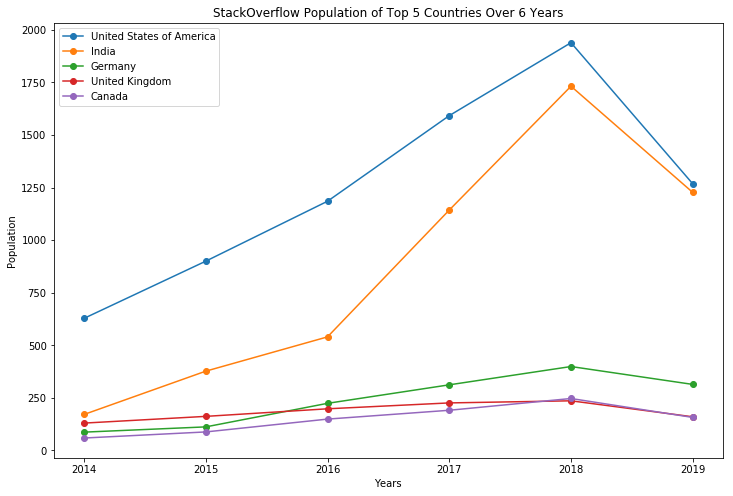

In [43]:
fig = plt.subplots(figsize = (12,8))
for index, row in data_top_5.iterrows():
    frame = df_users_full[df_users_full['Country']==row['Country']]
    frame = frame.groupby('YearCreated').size().reset_index()
    frame.columns = ['YearCreated','Population']
    plt.plot(frame.YearCreated,frame.Population, marker = 'o', label=row['Country'])
plt.legend()
plt.title('StackOverflow Population of Top 5 Countries Over 6 Years')
plt.xlabel('Years')
plt.ylabel('Population')

In [44]:
users_data_full.head()

,Id,Reputation,CreationDate,Location,Views,AccountId,Country
0,1,101,2014-05-13 22:58:54.810,"New York, NY",453,37099,United States of America
1,2,101,2014-05-13 22:59:19.787,"Corvallis, OR",9,2,United States of America
3,5,150,2014-05-13 23:16:11.013,"Texas, US",27,1266491,United States of America
4,6,101,2014-05-13 23:16:26.517,"Dietzenbach, Deutschland",10,935589,Germany
6,9,1042,2014-05-13 23:18:21.653,Canada,27,1369656,Canada
